<a href="https://www.kaggle.com/code/salilapte/data-mining-comment-classifier?scriptVersionId=214922650" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import re  # For regular expressions in text cleaning
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For advanced visualizations
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF vectorization
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.linear_model import LogisticRegression  # For Logistic Regression model
from sklearn.model_selection import KFold # For K-Fold model optimization
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)  # For model evaluation metrics

In [2]:
# Describing data
# Load the dataset
df = pd.read_csv('/kaggle/input/test-zencode-ds/file.csv')

# Total entries
print(df.count().sum())

# A brief overview
df.describe()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Class distribution in 'generated' column
class_distribution = df['label'].value_counts()
print("\nClass Distribution:\n", class_distribution)

# Text length analysis
df['text_length'] = df['texts'].apply(len)
# Summary statistics for text length
text_length_stats = df['text_length'].describe()
print("\nText Length Statistics:\n", text_length_stats)

11690
Missing Values:
 texts    0
label    0
dtype: int64

Class Distribution:
 label
1    2933
0    2912
Name: count, dtype: int64

Text Length Statistics:
 count    5845.000000
mean      572.784431
std        76.539849
min        90.000000
25%       527.000000
50%       576.000000
75%       621.000000
max       821.000000
Name: text_length, dtype: float64


In [3]:
# Data cleaning
# Function to clean text without NLTK
def clean_text_no_nltk(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove simple stopwords manually
    stop_words = {'the', 'and', 'is', 'in', 'to', 'of', 'for', 'it', 'on', 'this', 'that', 'with', 'a', 'as'}
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a cleaned string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['texts'].apply(clean_text_no_nltk)

# Display the first few rows to verify cleaning
print(df[['texts', 'cleaned_text']].head())

                                               texts  \
0  "It appears so, mon ami,” said Poirot cautious...   
1  There was only one diamond, my friend! Origina...   
2  But I can’t help feeling that it’s rather a fo...   
3  Pagett left the table half-way through the mea...   
4  ” The letter was written on a foreign type of ...   

                                        cleaned_text  
0  appears so mon ami said poirot cautiously appe...  
1  there was only one diamond my friend originall...  
2  but i cant help feeling its rather forlorn hop...  
3  pagett left table halfway through meal which a...  
4  letter was written foreign type paper bold cha...  


   text_length  word_count  avg_word_length
0          558          96         4.822917
1          485          85         4.717647
2          512          94         4.457447
3          443          81         4.481481
4          430          77         4.597403


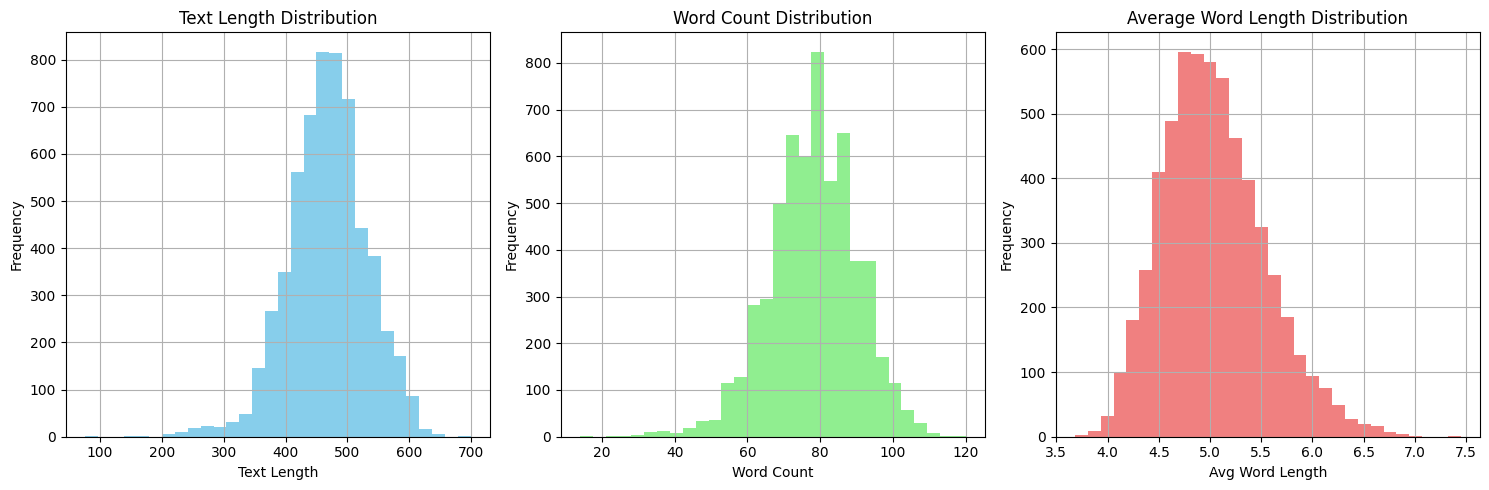

In [4]:
# Text length features
df['text_length'] = df['cleaned_text'].apply(len)
df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)

# Display the new features
print(df[['text_length', 'word_count', 'avg_word_length']].head())

# Plot histograms for each feature
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['text_length'].hist(bins=30, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
df['word_count'].hist(bins=30, color='lightgreen')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
df['avg_word_length'].hist(bins=30, color='lightcoral')
plt.title('Average Word Length Distribution')
plt.xlabel('Avg Word Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


TF-IDF Features (Unigrams and Bigrams):
       about  absolutely  across     after  again  against        ah       air  \
0  0.000000         0.0     0.0  0.105249    0.0      0.0  0.000000  0.000000   
1  0.098622         0.0     0.0  0.000000    0.0      0.0  0.151556  0.178866   
2  0.000000         0.0     0.0  0.000000    0.0      0.0  0.000000  0.000000   
3  0.000000         0.0     0.0  0.000000    0.0      0.0  0.000000  0.000000   
4  0.000000         0.0     0.0  0.000000    0.0      0.0  0.000000  0.000000   

        all  almost  ...  you see  you think  you were  you will  young  \
0  0.000000     0.0  ...      0.0    0.00000       0.0       0.0    0.0   
1  0.000000     0.0  ...      0.0    0.00000       0.0       0.0    0.0   
2  0.000000     0.0  ...      0.0    0.15012       0.0       0.0    0.0   
3  0.000000     0.0  ...      0.0    0.00000       0.0       0.0    0.0   
4  0.096583     0.0  ...      0.0    0.00000       0.0       0.0    0.0   

   young man     you

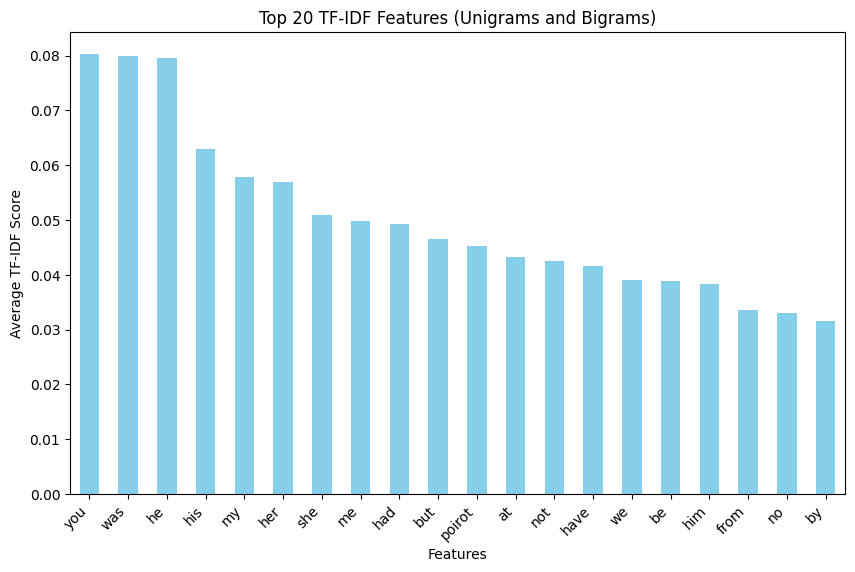

In [5]:
# TF-IDF Vectorization
# Extracting unigrams and bigrams using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Convert the TF-IDF matrix to a DataFrame for easier interpretation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the top features (unigrams and bigrams)
print("\nTF-IDF Features (Unigrams and Bigrams):\n", tfidf_df.head())

# Compute the average TF-IDF score for each feature
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Select the top 20 features
top_features = tfidf_mean.head(20)

# Plot the top features
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='skyblue')
plt.title('Top 20 TF-IDF Features (Unigrams and Bigrams)')
plt.ylabel('Average TF-IDF Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.show()

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)  # Reduce features for efficiency
X = vectorizer.fit_transform(df['texts'])
y = df['label']

Logistic Regression Accuracy: 0.932420872540633
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       604
           1       0.93      0.93      0.93       565

    accuracy                           0.93      1169
   macro avg       0.93      0.93      0.93      1169
weighted avg       0.93      0.93      0.93      1169

Accuracy with Heuristic Fix: 0.853721129170231
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       604
           1       0.78      0.96      0.86       565

    accuracy                           0.85      1169
   macro avg       0.87      0.86      0.85      1169
weighted avg       0.87      0.85      0.85      1169



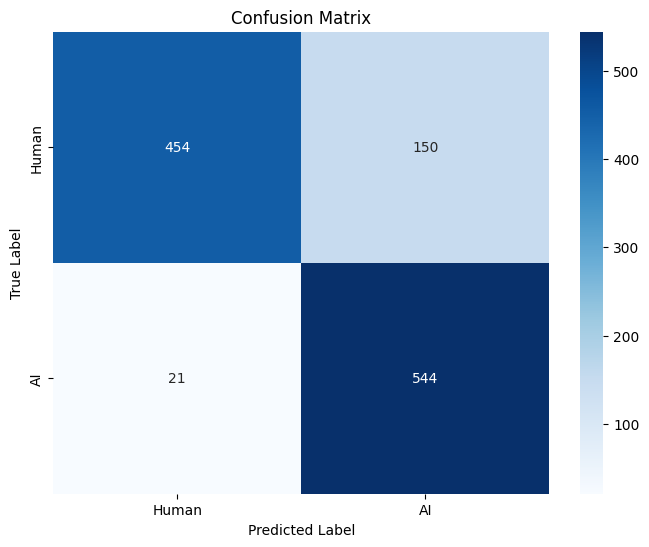

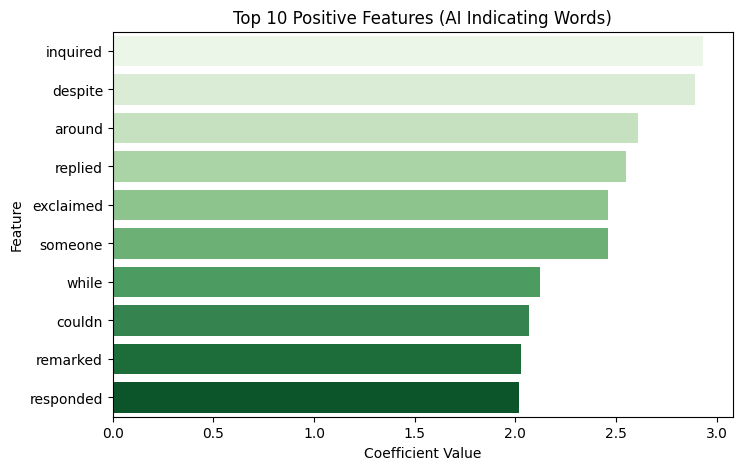

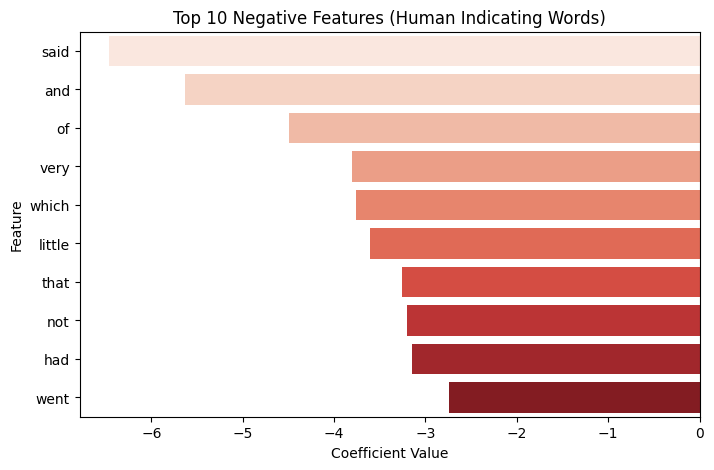

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


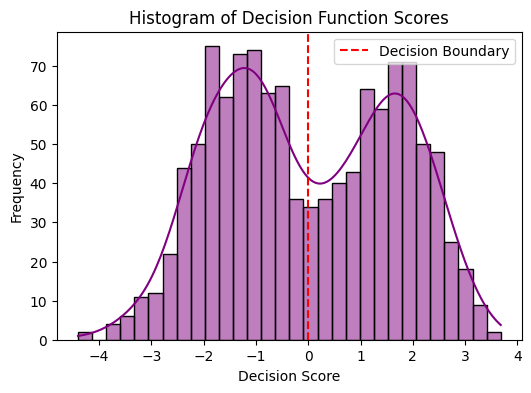

In [6]:
# Base Model Training using Logistic Regression
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, solver='liblinear')  # Ensure solver compatibility
log_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_model.predict(X_test)
y_score = log_model.decision_function(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Enhanced preprocessing function
def clean_text_enhanced(text):
    text = text.lower()
    # Remove only special characters, but keep punctuation
    text = re.sub(r'[^a-z\s.,;:!?]', '', text)
    return text

# Heuristic fix function
def heuristic_fix(text, prediction):
    human_keywords = ['virtue', 'nation', 'manly', 'citizen', 'flag', 'freedom']
    if sum(word in text.lower() for word in human_keywords) >= 3:
        return 0  # Bias towards "Human"
    return prediction

# Prediction and evaluation with heuristic fix
def predict_with_heuristic(input_text):
    cleaned_text = clean_text_enhanced(input_text)
    vectorized_text = vectorizer.transform([cleaned_text])
    raw_prediction = log_model.predict(vectorized_text)[0]
    return heuristic_fix(input_text, raw_prediction)

# Evaluate on test data
y_pred = []
for text in X_test:
    raw_text = vectorizer.inverse_transform(text)[0]  # Extract raw text from the vectorized input
    y_pred.append(predict_with_heuristic(' '.join(raw_text)))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with Heuristic Fix: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get coefficients from the logistic regression model
coefficients = log_model.coef_[0]

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Combine features and coefficients into a DataFrame
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Display top positive and negative coefficients
top_positive = coef_df.nlargest(10, 'Coefficient')
top_negative = coef_df.nsmallest(10, 'Coefficient')

# Plot top positive coefficients
plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=top_positive, palette='Greens')
plt.title('Top 10 Positive Features (AI Indicating Words)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Plot top negative coefficients
plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=top_negative, palette='Reds')
plt.title('Top 10 Negative Features (Human Indicating Words)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# **Visualization 5: Histogram of Predictions**
plt.figure(figsize=(6, 4))
sns.histplot(y_score, kde=True, bins=30, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Decision Boundary')
plt.title('Histogram of Decision Function Scores')
plt.xlabel('Decision Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9523097490744549

Classification Report for Optimized Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       604
           1       0.95      0.94      0.95       565

    accuracy                           0.95      1169
   macro avg       0.95      0.95      0.95      1169
weighted avg       0.95      0.95      0.95      1169



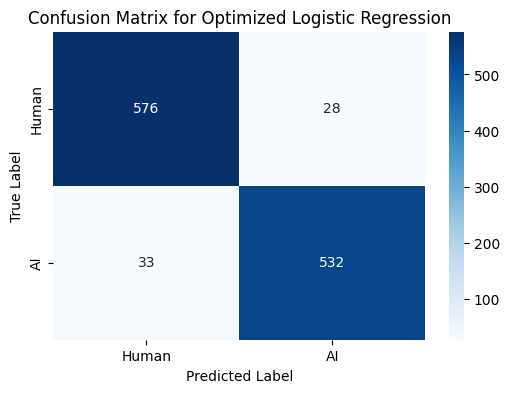

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'text' is the feature column and 'generated' is the target column
X_raw = df['texts']
y = df['label']

# Convert text to numeric features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X_raw)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['liblinear'],  # Solver compatible with L2
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters and cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report for Optimized Logistic Regression:")
print(classification_report(y_test, y_pred, zero_division=0))

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix for Optimized Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

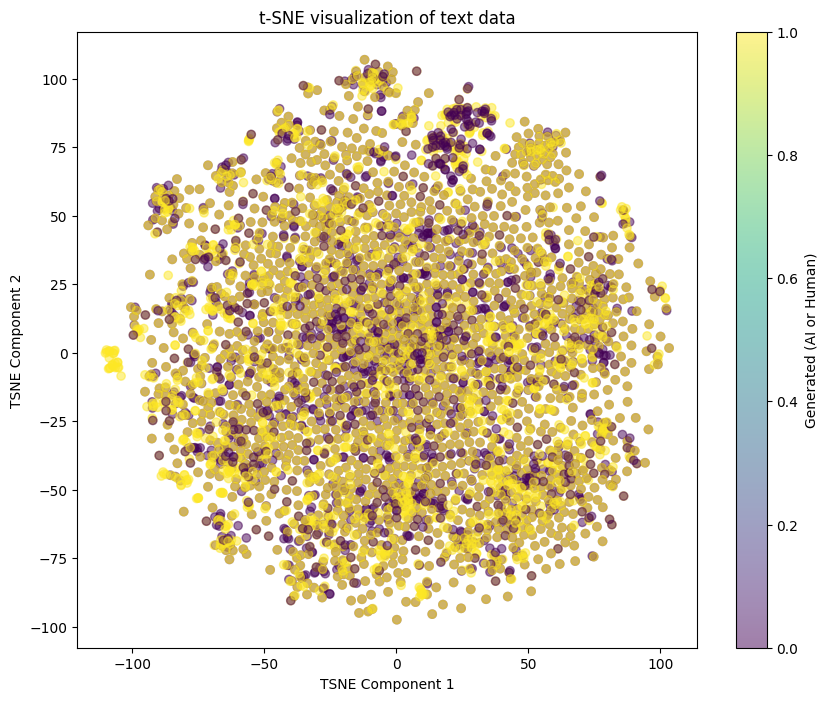

In [8]:
from sklearn.manifold import TSNE
# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['texts'].apply(clean_text_no_nltk)
df.head()
df_subset = df[:10000]
# Extract the text and target columns
X_raw = df_subset['cleaned_text']
y = df_subset['label']

# Convert text to numeric features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X_raw)
# Apply t-SNE to reduce the dimensionality of the data
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
X_tsne = tsne.fit_transform(X.toarray())  # Converting sparse matrix to dense array

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['generated'] = y
# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['generated'], cmap='viridis', alpha=0.5)
plt.title('t-SNE visualization of text data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.colorbar(label='Generated (AI or Human)')
plt.show()

In [10]:
# Generates .pkl files that can be used for local UI demo of the trained model
import pickle

# Save the trained Logistic Regression model
with open("log_model.pkl", "wb") as model_file:
    pickle.dump(log_model, model_file)

# Save the trained TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)